In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt


(train_x, train_y), (test_x, test_y) = utils.processed_data()

In [2]:
import os
import keras
import keras.layers as layers
import keras.models as models
import keras.backend as K
from model import LogGaussMF


def train_model():
    model = keras.Sequential([
        layers.Reshape((28,28,1), input_shape=(28,28)),
        layers.Conv2D(16, 3, strides=1, activation="relu", padding="same"),
        layers.Flatten(),
        LogGaussMF(10),
        layers.Lambda(lambda x: K.sum(x, axis=-1)),
        layers.Lambda(lambda x: K.exp(x - K.max(x, axis=-1, keepdims=True))),
        layers.Dense(10),
        layers.Activation("softmax")
    ])
    
    model.compile(
        optimizer=keras.optimizers.adam(lr=0.0005),
        loss="binary_crossentropy",
        metrics=[keras.metrics.categorical_accuracy])

    # train the model
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=64,
        epochs=20,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True)

    return model


if not os.path.exists("saved_models/"):
    os.makedirs("saved_models/")
    
if not os.path.exists("saved_models/rp_conv1_model.h5"):
    model = train_model()
    model.save("saved_models/rp_conv1_model.h5")
else:
    print("Loading saved model...", end=" ")
    model = keras.models.load_model(
    "saved_models/rp_conv1_model.h5",
    custom_objects={
        "LogGaussMF": lambda **x: LogGaussMF(rules=10, **x),
    })
    print("done.")

Using TensorFlow backend.


Loading saved model... 

W0401 22:07:29.722342 140403694245696 deprecation.py:323] From /home/ryan-desktop/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


done.


In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
log_gauss_mf_1 (LogGaussMF)  (None, 10, 12544)         250880    
_________________________________________________________________
lambda_1 (Lambda)            (None, 10)                0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
__________

[None, None, None, None, None, None, None, None, None, None]

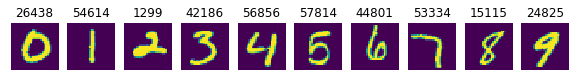

In [4]:
medoids = [26438, 54614, 1299, 42186, 56856, 57814, 44801, 53334, 15115, 24825]

fig, axes = plt.subplots(1, 10, figsize=(10,1))
for i, medoid in enumerate(medoids):
    axes[i].imshow(train_x[medoid])
    axes[i].set_title("{}".format(medoid))
    
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
#plt.tight_layout(h_pad=0, w_pad=0)

In [5]:
import innvestigate
from keras.models import Model


def analyze_representative(model, representative, top_k=10):
    assert(isinstance(model.layers[-6], layers.Flatten))
    assert(isinstance(model.layers[-5], LogGaussMF))
    assert(isinstance(model.layers[-4], layers.Lambda))
    assert(isinstance(model.layers[-3], layers.Lambda))
    assert(isinstance(model.layers[-2], layers.Dense))
    
    # outputs needed for analyzing the network
    features_tensor = model.layers[-6].output
    membership_tensor = model.layers[-5].output
    firing_strength_tensor = model.layers[-3].output
    logits_tensor = model.layers[-2].output
    
    # new model with the outputs from above
    analysis_model = Model(model.inputs, [
        features_tensor,
        membership_tensor,
        firing_strength_tensor,
        logits_tensor,
    ])
    
    # compute the values of those tensors on the representative
    features, log_membership, firing_strength, logits = analysis_model.predict(
        representative.reshape(1, 28, 28))
    
    # find and output the max logit
    logit_val, logit_idx = np.max(logits), np.argmax(logits)
    
    # find the rule that contributed most to the logit
    # this is computed as firing strength multiplied by the weights
    W = analysis_model.layers[-1].get_weights()[0]
    R = W[:,logit_idx] * firing_strength
    rule_val, rule_idx = np.max(R), np.argmax(R)
    
    # the maximum membership value does not appear to be a good indicator of the
    # most important membership function. a large number of rules seem to share
    # the maximum possible value of the membership function, 1.
    mu, beta = analysis_model.layers[-4].get_weights()
    R = np.exp(log_membership[:,rule_idx,:]) * features
    
    analysis = np.zeros((28, 28), np.float32)
    
    for i in range(top_k):
        membership_val = np.max(R)
        membership_idx = np.argmax(R)
        
        # zero the relevance value so that a new neuron is selected next time.
        R[0, membership_idx] = 0

        model_wo_softmax = Model(model.inputs, [model.layers[-6].output])
        analyzer = innvestigate.create_analyzer(
            "guided_backprop", 
            model_wo_softmax,
            neuron_selection_mode="index",
            allow_lambda_layers=True)

        a = analyzer.analyze(
            representative.reshape(1, 28, 28),
            membership_idx).squeeze()
        a /= np.max(a) * np.sqrt((i+1))
        
        analysis = np.maximum(analysis, a)
        
    analysis[representative < 0.5] *= -1    
    return analysis

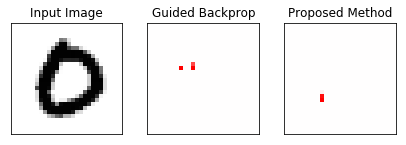

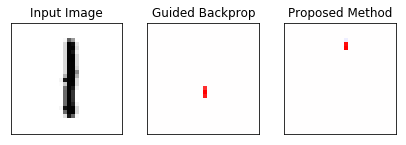

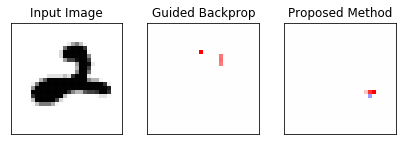

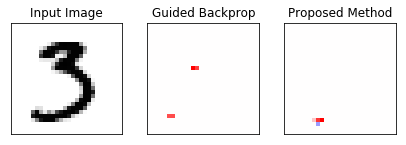

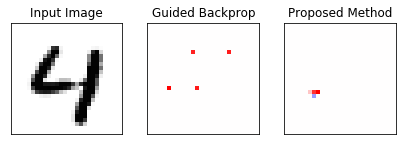

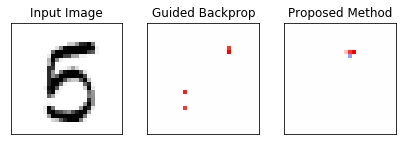

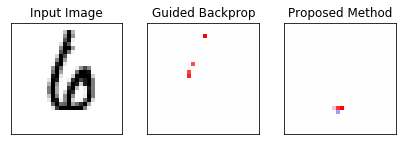

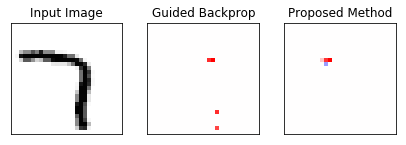

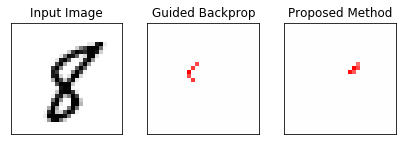

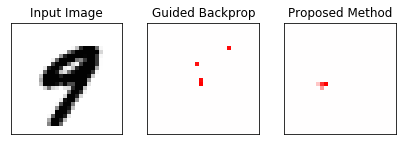

In [6]:
def compare_methods(model, medoid, threshold=1):
    fig, axes = plt.subplots(1, 3, figsize=(6,2))
    
    representative = train_x[medoid]
    axes[0].imshow(representative, cmap="Greys")
    axes[0].set_title("Input Image")
    
    model_wo_softmax = Model(model.inputs, [model.layers[-2].output])
    analyzer = innvestigate.create_analyzer(
        "guided_backprop", 
        model_wo_softmax,
        allow_lambda_layers=True)
    
    new_method = analyze_representative(model, representative, top_k=threshold)
    axes[2].imshow(new_method.squeeze(), cmap="bwr", vmin=-1., vmax=1.)
    axes[2].set_title("Proposed Method")
    
    guided_bp = analyzer.analyze(representative.reshape(1, 28, 28))
    masked = np.zeros((1, 28, 28))
    count = np.sum(new_method != 0)
    for i in range(count):
        idx = np.unravel_index(np.argmax(guided_bp, axis=None), guided_bp.shape)
        masked[idx] = guided_bp[idx]
        guided_bp[idx] = 0
    
    # format analysis
    masked /= np.max(masked)
    masked[medoid < 0.5] *= -1 
    
    axes[1].imshow(masked.squeeze(), cmap="bwr", vmin=-1., vmax=1.)
    axes[1].set_title("Guided Backprop")
    
    plt.setp(axes, xticks=[], yticks=[])
    plt.tight_layout(h_pad=0, w_pad=0)
    
    filename = "figures/cmp_digit{}_threshold{}.png"
    plt.savefig(filename.format(np.argmax(train_y[medoid]), threshold))
    
    
for medoid in medoids:
    compare_methods(model, medoid, threshold=1)

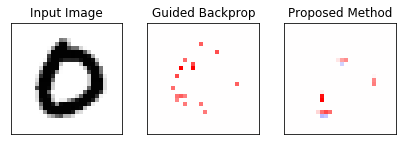

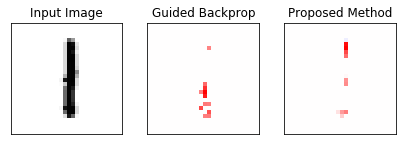

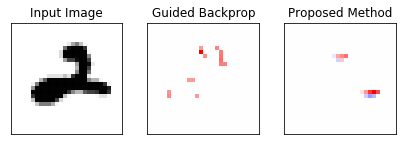

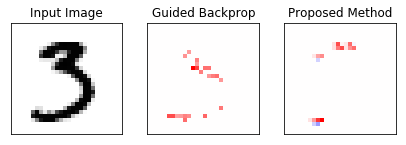

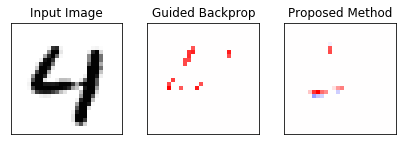

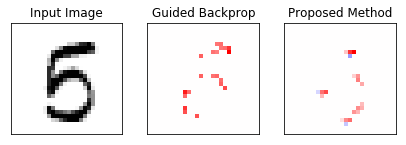

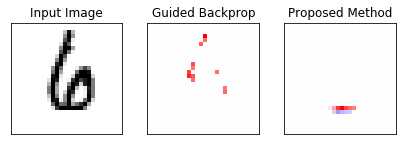

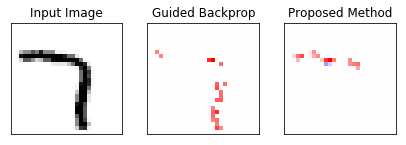

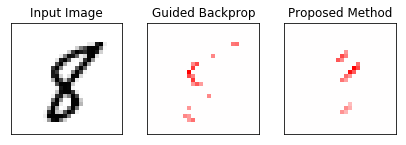

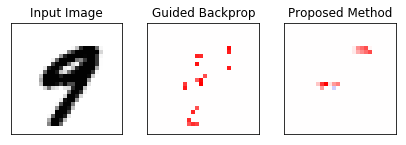

In [7]:
for medoid in medoids:
    compare_methods(model, medoid, threshold=5)

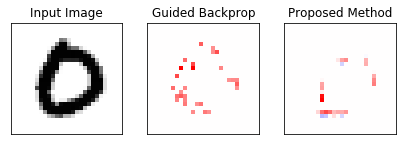

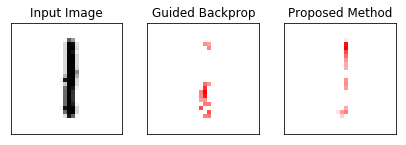

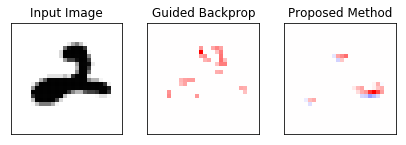

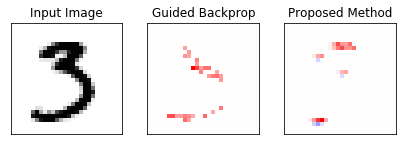

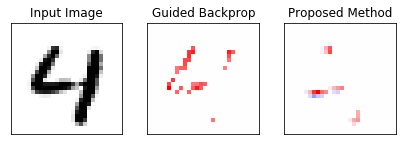

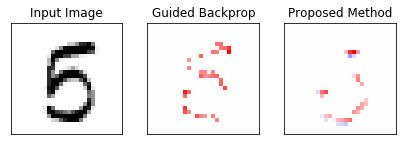

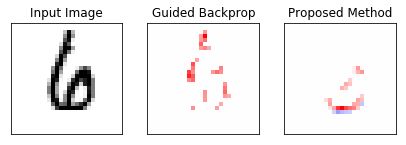

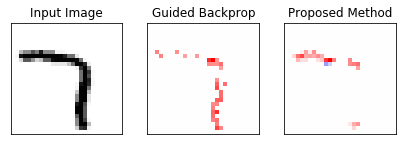

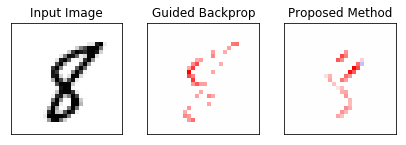

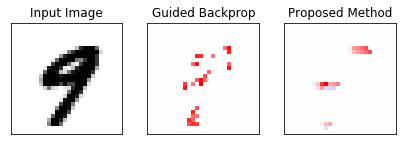

In [8]:
for medoid in medoids:
    compare_methods(model, medoid, threshold=10)

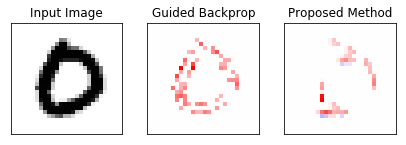

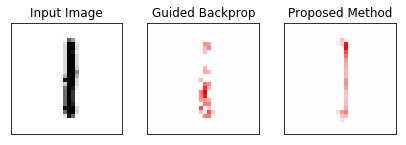

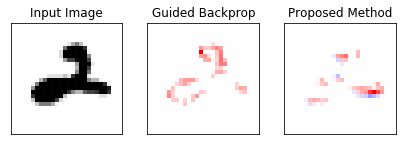

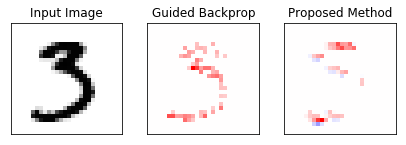

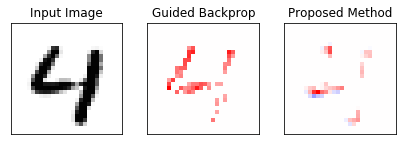

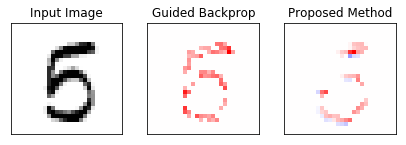

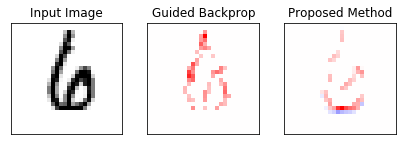

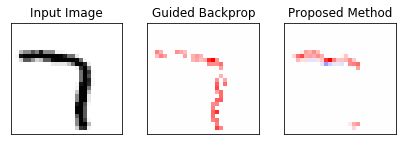

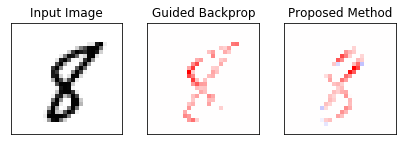

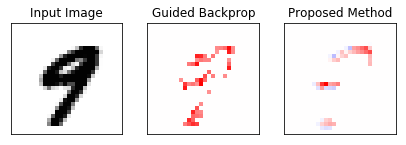

In [9]:
for medoid in medoids:
    compare_methods(model, medoid, threshold=20)